In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import time
import itertools
import pickle

In [ ]:
def mse(true, pred):
  return ((1/len(true))*np.sum((true.subtract(pred,0))**2,0)).values[0]

def mape(true, pred):
  return ((1/len(true))*np.sum(abs(true.subtract(pred,0))/true,0)).values[0]

def mae(true, pred):
  return ((1/len(true))*np.sum(abs(true.subtract(pred,0)),0)).values[0]

def r2(true, pred):
  return 1-(np.sum(((pred-true.T)**2).T,0)/np.sum((true- true.mean())**2,0)).values[0]

In [ ]:
class Preprocessing:
  def __init__(self,train_link):
    self.__csv_df = pd.read_csv(train_link, parse_dates = True, index_col = 0)

    #self.__csv_df = self.__csv_df.sample(frac = 1)
    
    trainn = self.__csv_df.loc[:"2017-11-30 23:00:00"]
    test = self.__csv_df.loc["2018-01-01 00:00:00":]
    val = self.__csv_df.loc["2017-12-01 00:00:00":"2017-12-31 23:00:00"]

    self.__Y_train = pd.DataFrame(trainn.iloc[:, -1])
    self.__Y_val = pd.DataFrame(val.iloc[:, -1])
    self.__Y_test = pd.DataFrame(test.iloc[:, -1])

    self.__X_train = pd.DataFrame(trainn.iloc[:, :-1])
    self.__X_val = pd.DataFrame(val.iloc[:, :-1])
    self.__X_test = pd.DataFrame(test.iloc[:, :-1])
    
    #self.__X_train = pd.DataFrame(self.__csv_df.iloc[:int(len(self.__csv_df)*0.75), :-1].values)
    #self.__Y_train = pd.DataFrame(self.__csv_df.iloc[:int(len(self.__csv_df)*0.75), -1].values.reshape(-1,1))
    #self.__Y_val = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.75):int(len(self.__csv_df)*0.8), -1].values.reshape(-1,1))
    #self.__X_val = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.75):int(len(self.__csv_df)*0.8), :-1].values)
    #self.__X_test = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.8):, :-1].values)
    #self.__Y_test = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.8):, -1].values.reshape(-1,1))
    
    self.__eigenvectors = []
    
    self.__pve_list = []
    self.__pca = 0
    self.__X_train_processed = 0
    self.__number_of_components = 0
    self.__scaler = 0
    self.__abs_max_scaler = []
    self.__min_max_scaler = []

  def get_Y_val(self):
    return self.__Y_val

  def get_Y_test(self):
    return self.__Y_test

  def get_Y_train(self):
    return self.__Y_train

  def get_X_val(self):
    return self.__X_val

  def min_max_scaling(self,dataframe):
    self.__min_max_scaler = []
    for column in dataframe.columns:
      self.__min_max_scaler.append((dataframe[column].min(),dataframe[column].max()))
      dataframe[column] = (dataframe[column] - dataframe[column].min())/(dataframe[column].max() - dataframe[column].min())
    return dataframe

  def min_max_scaling_test(self,dataframe):
    for column in dataframe.columns:
      column_n = dataframe.columns.get_loc(column)
      dataframe[column] = (dataframe[column] - self.__min_max_scaler[column_n][0])/(self.__min_max_scaler[column_n][1] - self.__min_max_scaler[column_n][0])
    return dataframe

  def abs_max_scaling(self,dataframe):
    for column in dataframe.columns:
      self.__abs_max_scaler.append(dataframe[column].abs().max())
      dataframe[column] = dataframe[column]  / dataframe[column].abs().max()
    return dataframe

  def preprocess_y_shape(self):
    self.__Y_test = self.min_max_scaling(self.__Y_test)
    self.__y_train = self.min_max_scaling(self.__Y_train)
    return self.__Y_test, self.__y_train

  def get_X_values(self):
    return self.__X_train, self.__X_test 
  
  def get_min_max_scaler(self):
    return self.__min_max_scaler

  def get_PCA_plot(self, threshold):
    df = self.__pve_list
    self.__number_of_components = [x+1 for x in range(len(df))]
    return self.__number_of_components, self.__pve_list

  def get_PVE(self):
    for i in range(len(self.__pve_list)):
      print(f"Number of components:{self.__number_of_components[i]} -> PVE:{self.__pve_list[i]}")
    
  def preprocess_train(self, X_train, threshold):
    X_train = self.min_max_scaling(self.__X_train)
    df_meaned = (X_train - np.mean(X_train, axis = 0))
    cov_matrix = np.cov(df_meaned, rowvar = False)
    values, vectors = np.linalg.eigh(cov_matrix)

    sorted_index = np.argsort(values)[::-1]
    sorted_eigenvalue = values[sorted_index]
    sorted_eigenvectors = vectors[:,sorted_index]

    pve = []
    for i in range(len(sorted_eigenvalue)):
        pve_percen = sum(sorted_eigenvalue[:i+1])*100 / np.sum(sorted_eigenvalue)
        pve.append(pve_percen)
    
    self.__pve_list = pve
    threshold_list = [pve.index(i) for i in pve if i >= threshold]
    threshold_out = threshold_list[0]

    sorted_index = sorted_index[:threshold_out+1]
    sorted_eigenvalue = sorted_eigenvalue[:threshold_out+1]
    sorted_eigenvectors = sorted_eigenvectors[:,:threshold_out+1]
    self.__eigenvectors = sorted_eigenvectors

    df_PCA = np.dot(sorted_eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_train = df_PCA
    return df_PCA
  
  def preprocess_test(self,X_test,X_train):
    X_test = self.min_max_scaling_test(self.__X_test)
    df_meaned = X_test - np.mean(X_train, axis = 0)
    df_PCA = np.dot(self.__eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_test = df_PCA
    return df_PCA
  def preprocess_val(self,X_val,X_train):
    X_val = self.min_max_scaling_test(self.__X_val)
    df_meaned = X_val - np.mean(X_train, axis = 0)
    df_PCA = np.dot(self.__eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_val = df_PCA
    return df_PCA

In [ ]:
dataframe = Preprocessing("/content/drive/MyDrive/EEE 485 Project/Code/Features_label_raw.csv")

In [ ]:
X_train,X_test = dataframe.get_X_values()
X_val = dataframe.get_X_val()

In [ ]:
def gradient_descent(features,L,Y_train,X_train):
  grad = np.zeros(len(features))
  for i in range(len(features[:-1])):
    
    grad[i] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1))*X_train.iloc[:,i])

  grad[-1] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1)))
  features -= L*grad
  return features

def gradient_descent_ridge(features,L,h,X_train, Y_train):
  grad = np.zeros(len(features))
  new_features = np.zeros(len(features))
  for i in range(len(features[:-1])):
    grad[i] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1))*X_train.iloc[:,i] + 2*h*features[i])
  grad[-1] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1)))
  new_features = features - L*grad
  features = new_features
  return features

def gradient_descent_lasso(features,L,h,X_train, Y_train):
  grad = np.zeros(len(features))
  for i in range(len(features[:-1])):
    if features[i] > 0:
      grad[i] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1))*X_train.iloc[:,i] + h)
    else:
      grad[i] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1))*X_train.iloc[:,i] - h)
  grad[-1] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1)))
  features -= L*grad
  return features

def mini_batch_gradient_descent(features,X_train,Y_train,batch_size,L):
  grad = np.zeros(len(features))
  X_train_batch = X_train.iloc[np.random.randint(len(X_train),size = batch_size)]
  Y_train_batch = Y_train.iloc[np.random.randint(len(Y_train),size = batch_size)]
  for i in range(len(features[:-1])):
    grad[i] = -(2/len(Y_train_batch))*np.sum((np.sum(Y_train_batch,1)-np.sum(X_train_batch*features[:-1]+ features[-1],1))*X_train_batch.iloc[:,i])

  grad[-1] = -(2/len(Y_train_batch))*np.sum((np.sum(Y_train_batch,1)-np.sum(X_train_batch*features[:-1]+ features[-1],1)))
  features -= L*grad
  return features

In [ ]:
def loss_function(features,Xx,Y):
  RSS = 0
  error = np.sum((np.sum(Y,1)-np.sum(Xx*features[:-1]+ features[-1],1))**2)
  RSS = error/(2*Xx.shape[0])
  return RSS 

In [ ]:
def gradient_descent_elasticnet(features,L,h,p):
  
  grad = np.zeros(len(features))
  for i in range(len(features[:-1])):
    if features[i] > 0:
      grad[i] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1))*X_train.iloc[:,i] + h+2*p*features[i])
    else:
      grad[i] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1))*X_train.iloc[:,i] - h)
  grad[-1] = -(2/len(Y_train))*np.sum((np.sum(Y_train,1)-np.sum(X_train*features[:-1]+ features[-1],1)))
  features -= L*grad
  return features

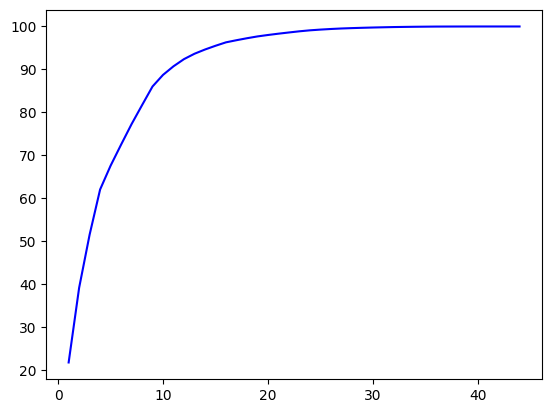

In [ ]:
(x_axis,y_axis) = dataframe.get_PCA_plot(100)
plt.plot(x_axis,y_axis,"b")

In [ ]:
X_test = dataframe.preprocess_test(X_test, X_train_o)
X_val = dataframe.preprocess_val(X_val, X_train_o)
X_test

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,principal_componenet 11,principal_componenet 12,principal_componenet 13,principal_componenet 14,principal_componenet 15
0,0.905375,-0.338786,-1.114445,0.590819,0.102919,0.106314,-0.663717,0.178964,-0.566710,0.095357,-0.611649,0.120034,0.321502,-0.088544,0.244745
1,0.914154,-0.354194,-1.104246,0.722568,0.009966,0.062078,-0.609061,0.175058,-0.565348,0.097795,-0.591383,-0.001199,0.348827,-0.110551,0.153674
2,0.938330,-0.368005,-1.099667,0.844191,-0.093578,0.006572,-0.530479,0.158628,-0.558699,0.054835,-0.501439,-0.097370,0.306235,-0.141045,0.018249
3,0.970441,-0.392735,-1.079100,0.972731,-0.217000,-0.047379,-0.447537,0.141804,-0.546708,0.024121,-0.456399,-0.146452,0.202433,-0.084582,0.069038
4,0.974019,-0.413587,-1.058642,1.045566,-0.352577,-0.084639,-0.399378,0.134414,-0.551283,0.053181,-0.522419,-0.110228,0.188150,-0.050642,0.144802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,0.921221,-0.002203,-1.260984,0.014115,0.154971,0.097536,-0.616267,0.042568,-0.435353,-0.092712,-0.020792,-0.450658,-0.178836,-0.033775,-0.096954
8752,0.940821,-0.020134,-1.273776,-0.017981,0.261385,0.111602,-0.625361,0.046298,-0.431225,-0.176513,0.019898,-0.431956,-0.083190,-0.016851,-0.022965
8753,0.972651,-0.059168,-1.257667,0.074940,0.306755,0.111405,-0.613911,0.050841,-0.431960,-0.219211,-0.005444,-0.380743,-0.028058,0.044973,0.161939
8754,0.996949,-0.099713,-1.232641,0.233913,0.281293,0.091970,-0.587537,0.053246,-0.437316,-0.215406,-0.033933,-0.382377,0.008075,0.055178,0.196454


In [ ]:
Y_train = dataframe.get_Y_train().reset_index().drop("index",axis=1)
Y_test = dataframe.get_Y_test().reset_index().drop("index",axis=1)
Y_val = dataframe.get_Y_val().reset_index().drop("index",axis=1)
Y_train = dataframe.min_max_scaling(Y_train)
Y_val = dataframe.min_max_scaling_test(Y_val)
Y_test = dataframe.min_max_scaling_test(Y_test)
dataframe.get_min_max_scaler()

[(0.0, 41015.0)]

#PCA Gradient Descent Grid Search

In [ ]:
parameters = {"lr": [0.016,0.018,0.20],
              "epoch": [350,500,1000],
              #"h":[0.0001]
}
param_values = [v for v in parameters.values()] 
error_of_choice= []
whole_turns = []
threshold = 100
for lr,epoch in itertools.product(*param_values):
  t = time.time()
  features =  np.ones(X_train.shape[1]+1)/5
  for i in range(epoch):
      features = gradient_descent(features, lr,Y_train,X_train)
  y_pred = np.sum(X_val*features[:-1]+ features[-1],1)
  MSE = mse(Y_val,y_pred)
  error_of_choice.append(MSE)
  whole_turns.append([lr,epoch])
  print('learning rate: %.3f, epoch: %.3f, MSE:%.3f' % (lr,epoch,MSE))
  print("Duration: " + str(time.time()-t) + " seconds\n")
  if MSE < threshold:
    threshold = MSE
    model = features
    LR = lr
    E = epoch

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Gradient_Descent.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, model], f, protocol=pickle.HIGHEST_PROTOCOL)   
print("Best Learning Rate: " + str(LR))
print("Best Epoch Number: " + str(E))

learning rate: 0.016, epoch: 350.000, MSE:0.006
Duration: 20.29844093322754 seconds

learning rate: 0.016, epoch: 500.000, MSE:0.004
Duration: 28.487324476242065 seconds

learning rate: 0.016, epoch: 1000.000, MSE:0.002
Duration: 57.49893856048584 seconds

learning rate: 0.018, epoch: 350.000, MSE:0.005
Duration: 19.67838454246521 seconds

learning rate: 0.018, epoch: 500.000, MSE:0.003
Duration: 28.5837242603302 seconds

learning rate: 0.018, epoch: 1000.000, MSE:0.002
Duration: 57.09693884849548 seconds

learning rate: 0.200, epoch: 350.000, MSE:inf
Duration: 23.87622094154358 seconds



<ipython-input-10-995bc2a12b8c>:8: RuntimeWarning: invalid value encountered in subtract
  features -= L*grad


learning rate: 0.200, epoch: 500.000, MSE:0.515
Duration: 30.846619606018066 seconds



<ipython-input-10-995bc2a12b8c>:8: RuntimeWarning: invalid value encountered in subtract
  features -= L*grad


learning rate: 0.200, epoch: 1000.000, MSE:0.515
Duration: 78.56073808670044 seconds

Best Learning Rate: 0.018
Best Epoch Number: 1000


In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Gradient_Descent.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = np.sum(X_val*features_p[:-1]+ features_p[-1],1)
print("MSE: " + str(mse(Y_val,y_pred_p)))
print("MAE: " + str(mae(Y_val,y_pred_p)))
print("R2 Score: " + str(r2(Y_val,y_pred_p)))

MSE: 0.0020016357096768415
MAE: 0.035284800673513216
R2 Score: 0.8685979014587035


# PCA Gradient Descent

In [ ]:
#features = []
#for i in range(X_train.shape[1]+1):
#  features.append(np.random.normal(loc=0.0, scale=1.0)*0.05)
#features = list(np.random.randint(low = 0,high=5,size=X_train.shape[1]+1)/20)
features =  np.ones(X_train.shape[1]+1)/5
L = 0.018
epochs = 1000
xlist = []
ylist = []

t = time.time()
for i in range(epochs):
    features = gradient_descent(features, L,Y_train,X_train)
    xlist.append(i)
    ylist.append(loss_function(features,X_train, Y_train)) 
print("Duration: " + str(time.time()-t) + " seconds")
print(features)

Duration: 62.00121450424194 seconds
[-0.01046776  0.0250264  -0.02993664 -0.16031821  0.02369164 -0.01160694
  0.02656945 -0.01241427  0.00444995 -0.11076245  0.10803251  0.07043934
  0.09515052  0.06666864  0.06836471  0.0463842 ]


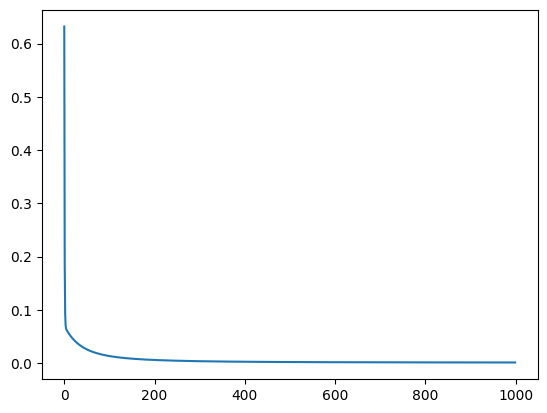

In [ ]:
plt.plot(xlist,ylist)

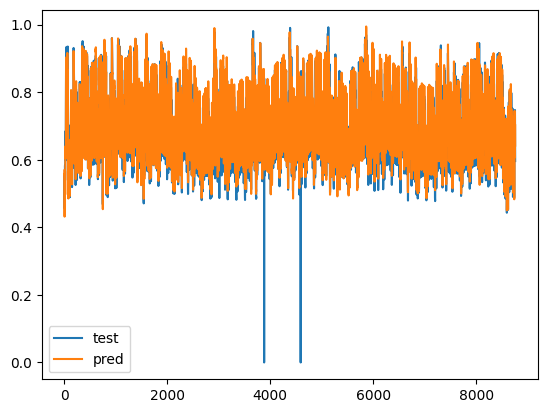

In [ ]:
y_pred = np.sum(X_test*features[:-1]+ features[-1],1)

plt.plot(y_pred.index, Y_test)
plt.plot(y_pred.index, y_pred)
plt.legend(["test","pred"])

In [ ]:
y_pred_train = np.sum(X_train*features[:-1]+ features[-1],1)
print("Train MSE: " + str(mse(Y_train,y_pred_train)))
print("Train MAE: " + str(mae(Y_train,y_pred_train)))
print("Train R2 Score: " + str(r2(Y_train,y_pred_train)))

print("Test MSE: " + str(mse(Y_test,y_pred)))
print("Test MAE: " + str(mae(Y_test,y_pred)))
print("Test R2 Score: " + str(r2(Y_test,y_pred)))

Train MSE: 0.0021793440832769385
Train MAE: 0.033422785616739115
Train R2 Score: 0.826491523393119
Test MSE: 0.0018949939805878026
Test MAE: 0.033614551805270704
Test R2 Score: 0.8523596817038456


# PCA LASSO Grid Search

In [ ]:
parameters = {"lr": [0.016,0.018,0.20],
              "h":[0.00001,0.0001,0.001]
}
param_values = [v for v in parameters.values()] 
error_of_choice= []
whole_turns = []
threshold = 100
for lr,h in itertools.product(*param_values):
  t = time.time()
  features =  np.ones(X_train.shape[1]+1)/5
  for i in range(1000):
      features = gradient_descent_lasso(features,lr,h, X_train,Y_train)
  y_pred = np.sum(X_val*features[:-1]+ features[-1],1)
  MSE = mse(Y_val,y_pred)
  error_of_choice.append(MSE)
  whole_turns.append([lr,epoch])
  print('learning rate: %.3f, epoch: %.3f, MSE:%.3f' % (lr,h,MSE))
  print("Duration: " + str(time.time()-t) + " seconds\n")
  if MSE < threshold:
    threshold = MSE
    model = features
    LR = lr
    E = h

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_LASSO.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, model], f, protocol=pickle.HIGHEST_PROTOCOL)   
print("Best Learning Rate: " + str(LR))
print("Best Penalty Term: " + str(E))

learning rate: 0.016, epoch: 0.000, MSE:0.002
Duration: 60.24277949333191 seconds

learning rate: 0.016, epoch: 0.000, MSE:0.002
Duration: 60.190425634384155 seconds

learning rate: 0.016, epoch: 0.001, MSE:0.003
Duration: 59.776692628860474 seconds

learning rate: 0.018, epoch: 0.000, MSE:0.002
Duration: 60.41043829917908 seconds

learning rate: 0.018, epoch: 0.000, MSE:0.002
Duration: 60.09911298751831 seconds

learning rate: 0.018, epoch: 0.001, MSE:0.002
Duration: 60.616373777389526 seconds



<ipython-input-10-995bc2a12b8c>:29: RuntimeWarning: invalid value encountered in subtract
  features -= L*grad


learning rate: 0.200, epoch: 0.000, MSE:0.515
Duration: 80.6017529964447 seconds



<ipython-input-10-995bc2a12b8c>:29: RuntimeWarning: invalid value encountered in subtract
  features -= L*grad


learning rate: 0.200, epoch: 0.000, MSE:0.515
Duration: 80.68077421188354 seconds



<ipython-input-10-995bc2a12b8c>:29: RuntimeWarning: invalid value encountered in subtract
  features -= L*grad


learning rate: 0.200, epoch: 0.001, MSE:0.515
Duration: 80.9333324432373 seconds

Best Learning Rate: 0.018
Best Penalty Term: 1e-05


In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_LASSO.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = np.sum(X_test_p*features_p[:-1]+ features_p[-1],1)
print("MSE: " + str(mse(Y_test_p,y_pred_p)))
print("MAPE: " + str(mape(Y_test_p,y_pred_p)))
print("MAE: " + str(mae(Y_test_p,y_pred_p)))
print("R2 Score: " + str(r2(Y_test_p,y_pred_p)))

MSE: 0.0018977841849407444
MAPE: inf
MAE: 0.033642037645726625
R2 Score: 0.852142294913703


# LASSO

In [ ]:
features =  np.ones(X_train.shape[1]+1)/5
L = 0.018
h = 1e-5
epochs = 1000
xlist = []
ylist = []

t = time.time()
for i in range(epochs):
    features =gradient_descent_lasso(features,L,h, X_train,Y_train)
    xlist.append(i)
    ylist.append(loss_function(features,X_train, Y_train))
print("Duration: " + str(time.time()-t) + " seconds")
print(features)

Duration: 62.42020869255066 seconds
[-0.01048348  0.02504618 -0.02996445 -0.16035093  0.02375347 -0.01166381
  0.02664095 -0.01247034  0.00452815 -0.11085918  0.10818319  0.07060953
  0.09535136  0.06689347  0.06860109  0.0463842 ]


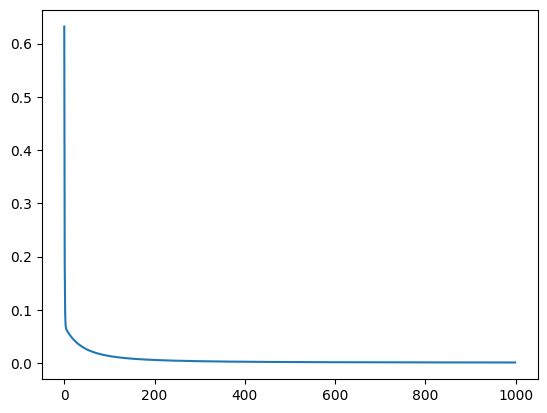

In [ ]:
plt.plot(xlist,ylist)

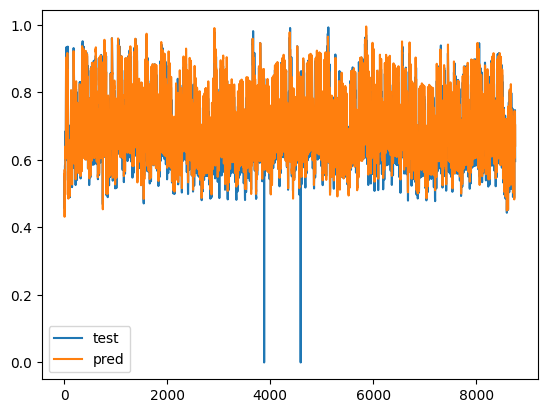

In [ ]:
y_pred = np.sum(X_test*features[:-1]+ features[-1],1)

plt.plot(y_pred.index, Y_test)
plt.plot(y_pred.index, y_pred)
plt.legend(["test","pred"])

In [ ]:
y_pred_train = np.sum(X_train*features[:-1]+ features[-1],1)
print("Train MSE: " + str(mse(Y_train,y_pred_train)))
print("Train MAE: " + str(mae(Y_train,y_pred_train)))
print("Train R2 Score: " + str(r2(Y_train,y_pred_train)))

print("Test MSE: " + str(mse(Y_test,y_pred)))
print("Test MAE: " + str(mae(Y_test,y_pred)))
print("Test R2 Score: " + str(r2(Y_test,y_pred)))

Train MSE: 0.002182335643464348
Train MAE: 0.03344794337352941
Train R2 Score: 0.8262533503323444
Test MSE: 0.0018977841849407444
Test MAE: 0.033642037645726625
Test R2 Score: 0.852142294913703


# Ridge Grid Search

In [ ]:
parameters = {"lr": [0.016,0.018,0.20],
              "h":[0.00001,0.0001,0.001]
}
param_values = [v for v in parameters.values()] 
error_of_choice= []
whole_turns = []
threshold = 100
for lr,h in itertools.product(*param_values):
  t = time.time()
  features =  np.ones(X_train.shape[1]+1)/5
  for i in range(1000):
      features = gradient_descent_ridge(features,lr,h, X_train,Y_train)
  y_pred = np.sum(X_val*features[:-1]+ features[-1],1)
  MSE = mse(Y_val,y_pred)
  error_of_choice.append(MSE)
  whole_turns.append([lr,epoch])
  print('learning rate: %.3f, epoch: %.3f, MSE:%.3f' % (lr,h,MSE))
  print("Duration: " + str(time.time()-t) + " seconds\n")
  if MSE < threshold:
    threshold = MSE
    model = features
    LR = lr
    E = h

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Ridge.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, model], f, protocol=pickle.HIGHEST_PROTOCOL)   
print("Best Learning Rate: " + str(LR))
print("Best Penalty Term: " + str(E))

learning rate: 0.016, epoch: 0.000, MSE:0.002
Duration: 61.020386934280396 seconds

learning rate: 0.016, epoch: 0.000, MSE:0.002
Duration: 63.0974555015564 seconds

learning rate: 0.016, epoch: 0.001, MSE:0.002
Duration: 62.31387233734131 seconds

learning rate: 0.018, epoch: 0.000, MSE:0.002
Duration: 60.18643593788147 seconds

learning rate: 0.018, epoch: 0.000, MSE:0.002
Duration: 61.826847553253174 seconds

learning rate: 0.018, epoch: 0.001, MSE:0.002
Duration: 60.788350343704224 seconds



<ipython-input-10-995bc2a12b8c>:17: RuntimeWarning: invalid value encountered in subtract
  new_features = features - L*grad


learning rate: 0.200, epoch: 0.000, MSE:0.515
Duration: 83.78374600410461 seconds



<ipython-input-10-995bc2a12b8c>:17: RuntimeWarning: invalid value encountered in subtract
  new_features = features - L*grad


learning rate: 0.200, epoch: 0.000, MSE:0.515
Duration: 82.42906594276428 seconds



<ipython-input-10-995bc2a12b8c>:17: RuntimeWarning: invalid value encountered in subtract
  new_features = features - L*grad


learning rate: 0.200, epoch: 0.001, MSE:0.515
Duration: 83.0246753692627 seconds

Best Learning Rate: 0.018
Best Penalty Term: 1e-05


In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_Ridge.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = np.sum(X_test_p*features_p[:-1]+ features_p[-1],1)
print("MSE: " + str(mse(Y_test_p,y_pred_p)))
print("MAPE: " + str(mape(Y_test_p,y_pred_p)))
print("MAE: " + str(mae(Y_test_p,y_pred_p)))
print("R2 Score: " + str(r2(Y_test_p,y_pred_p)))

MSE: 0.0018955571073630282
MAPE: inf
MAE: 0.03361959511696549
R2 Score: 0.8523158080993977


# Ridge

In [ ]:
features =  np.ones(X_train.shape[1]+1)/5
L = 0.018
h = 1e-5
epochs = 1000
xlist = []
ylist = []

t = time.time()
for i in range(epochs):
    features =gradient_descent_ridge(features,L,h, X_train,Y_train)
    xlist.append(i)
    ylist.append(loss_function(features,X_train, Y_train))
print("Duration: " + str(time.time()-t) + " seconds")
print(features)

Duration: 69.59292960166931 seconds
[-0.01046808  0.02502739 -0.0299383  -0.1603287   0.02369489 -0.01160783
  0.02657392 -0.012415    0.00445181 -0.1107796   0.10807048  0.07047372
  0.09520114  0.0667187   0.068419    0.0463842 ]


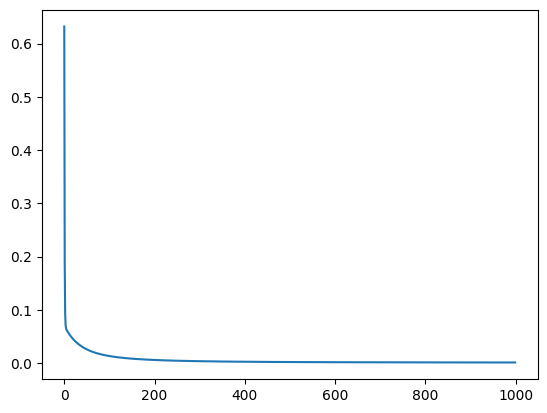

In [ ]:
plt.plot(xlist,ylist)

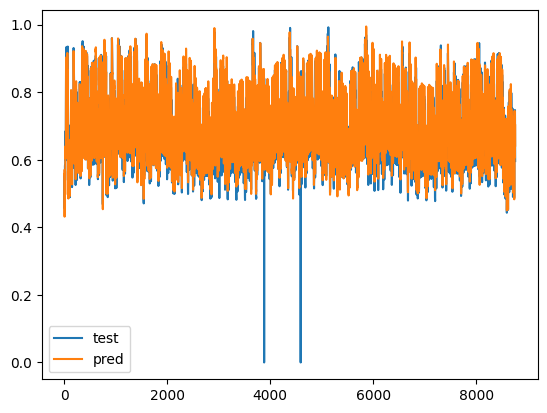

In [ ]:
y_pred = np.sum(X_test*features[:-1]+ features[-1],1)

plt.plot(y_pred.index, Y_test)
plt.plot(y_pred.index, y_pred)
plt.legend(["test","pred"])

In [ ]:
y_pred_train = np.sum(X_train*features[:-1]+ features[-1],1)
print("Train MSE: " + str(mse(Y_train,y_pred_train)))
print("Train MAE: " + str(mae(Y_train,y_pred_train)))
print("Train R2 Score: " + str(r2(Y_train,y_pred_train)))

print("Test MSE: " + str(mse(Y_test,y_pred)))
print("Test MAE: " + str(mae(Y_test,y_pred)))
print("Test R2 Score: " + str(r2(Y_test,y_pred)))

Train MSE: 0.00218003975284336
Train MAE: 0.033428782628178715
Train R2 Score: 0.826436137661413
Test MSE: 0.0018955571073630282
Test MAE: 0.03361959511696549
Test R2 Score: 0.8523158080993977


# ElasticNet Grid Search

In [ ]:
parameters = {"lr": [0.018],
              "h":[0.00001,0.0001,0.001],
              "p":[0.00001,0.0001,0.001],
               "epoch": [1000],
}
param_values = [v for v in parameters.values()] 
error_of_choice= []
whole_turns = []
threshold = 100
for lr,h,p,epoch in itertools.product(*param_values):
  t = time.time()
  features =  np.ones(X_train.shape[1]+1)/5
  for i in range(epoch):
      features = gradient_descent_elasticnet(features,lr,h,p)
  y_pred = np.sum(X_val*features[:-1]+ features[-1],1)
  MSE = mse(Y_val,y_pred)
  error_of_choice.append(MSE)
  whole_turns.append([lr,epoch])
  print('h: %.5f, p: %.5f,epoch: %.0f, MSE:%.16f' % (h,p,epoch,MSE))
  print("Duration: " + str(time.time()-t) + " seconds\n")
  if MSE < threshold:
    threshold = MSE
    model = features
    LR = lr
    H = h
    P = p
    EPOCH = epoch

with open('/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_ElasticNet.pickle', 'wb') as f:
    pickle.dump([X_train, Y_train, X_test, Y_test, model], f, protocol=pickle.HIGHEST_PROTOCOL)   
print("Best Learning Rate: " + str(LR))
print("Best H Term: " + str(H))
print("Best P Term: " + str(P))
print("Best Epoch Term: " + str(EPOCH))

h: 0.00001, p: 0.00001,epoch: 1000, MSE:0.0020053949866512
Duration: 62.627907276153564 seconds

h: 0.00001, p: 0.00010,epoch: 1000, MSE:0.0020124038601521
Duration: 62.80130481719971 seconds

h: 0.00001, p: 0.00100,epoch: 1000, MSE:0.0020882718452391
Duration: 62.59945249557495 seconds

h: 0.00010, p: 0.00001,epoch: 1000, MSE:0.0020336827903242
Duration: 62.10176682472229 seconds

h: 0.00010, p: 0.00010,epoch: 1000, MSE:0.0020410907238030
Duration: 63.0042941570282 seconds

h: 0.00010, p: 0.00100,epoch: 1000, MSE:0.0021211357868740
Duration: 62.91221475601196 seconds

h: 0.00100, p: 0.00001,epoch: 1000, MSE:0.0024524461907292
Duration: 61.70615816116333 seconds

h: 0.00100, p: 0.00010,epoch: 1000, MSE:0.0024643145007078
Duration: 61.828267097473145 seconds

h: 0.00100, p: 0.00100,epoch: 1000, MSE:0.0025909966369037
Duration: 62.424001693725586 seconds

Best Learning Rate: 0.018
Best H Term: 1e-05
Best P Term: 1e-05
Best Epoch Term: 1000


In [ ]:
filename = "/content/drive/MyDrive/EEE 485 Project/Code/code_final/PCA_ElasticNet.pickle"
pick = pickle.load(open(filename, 'rb'))
X_train_p, Y_train_p, X_test_p, Y_test_p, features_p = pick
y_pred_p = np.sum(X_test_p*features_p[:-1]+ features_p[-1],1)
print("MSE: " + str(mse(Y_test_p,y_pred_p)))
print("MAPE: " + str(mape(Y_test_p,y_pred_p)))
print("MAE: " + str(mae(Y_test_p,y_pred_p)))
print("R2 Score: " + str(r2(Y_test_p,y_pred_p)))

MSE: 0.0018984134527662226
MAPE: inf
MAE: 0.03364767505475066
R2 Score: 0.8520932682133551


#ElasticNet

In [ ]:
features =  np.ones(X_train.shape[1]+1)/5
L = 0.018
h = 1e-05
p = 1e-05
epochs = 1000
xlist = []
ylist = []

t = time.time()
for i in range(epochs):
    features =gradient_descent_elasticnet(features,lr,h,p)
    xlist.append(i)
    ylist.append(loss_function(features,X_train, Y_train))
print("Duration: " + str(time.time()-t) + " seconds")
print(features)

Duration: 67.59293222427368 seconds
[-0.01048348  0.02504717 -0.02996445 -0.16035093  0.02375672 -0.01166348
  0.02664543 -0.01246976  0.00453002 -0.11085755  0.10822119  0.07064395
  0.09540204  0.06694359  0.06865545  0.0463842 ]


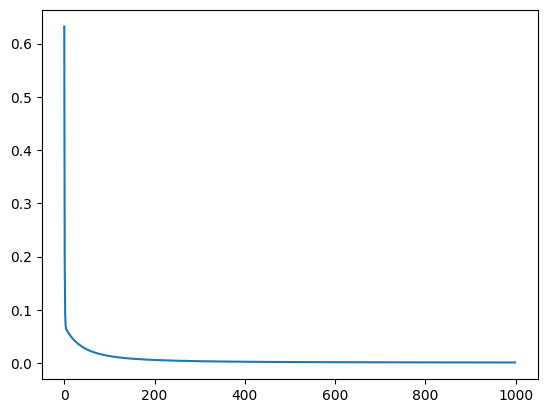

In [ ]:
plt.plot(xlist,ylist)

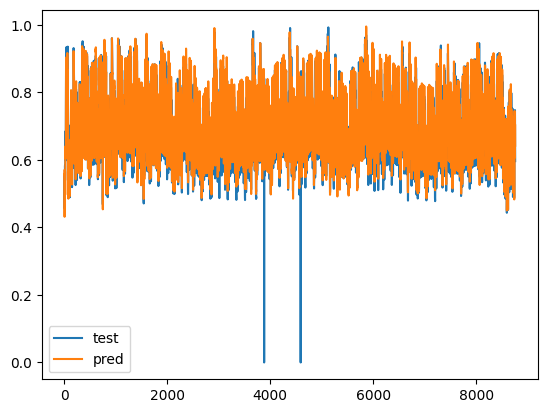

In [ ]:
y_pred = np.sum(X_test*features[:-1]+ features[-1],1)

plt.plot(y_pred.index, Y_test)
plt.plot(y_pred.index, y_pred)
plt.legend(["test","pred"])

In [ ]:
y_pred_train = np.sum(X_train*features[:-1]+ features[-1],1)
print("Train MSE: " + str(mse(Y_train,y_pred_train)))
print("Train MAE: " + str(mae(Y_train,y_pred_train)))
print("Train R2 Score: " + str(r2(Y_train,y_pred_train)))

print("Test MSE: " + str(mse(Y_test,y_pred)))
print("Test MAE: " + str(mae(Y_test,y_pred)))
print("Test R2 Score: " + str(r2(Y_test,y_pred)))

Train MSE: 0.002183094509558717
Train MAE: 0.033454870370830066
Train R2 Score: 0.8261929332091407
Test MSE: 0.0018984134527662226
Test MAE: 0.03364767505475066
Test R2 Score: 0.8520932682133551
